In [1]:
import os
import torch
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from transformers import pipeline, BertTokenizer, TFBertForSequenceClassification, DetrImageProcessor, DetrForObjectDetection
from PIL import Image
from diffusers import StableDiffusionPipeline
from huggingface_hub import login

/home/iabd/anaconda3/envs/entornoJon/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-02-10 19:50:52.035690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 19:50:52.042989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 19:50:52.051594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory f

In [2]:
tf.config.set_visible_devices([], 'GPU')

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Crecimiento de memoria configurado para las GPUs.")
    except RuntimeError as e:
        print(f"Error al configurar crecimiento de memoria: {e}")

Crecimiento de memoria configurado para las GPUs.


I0000 00:00:1739213456.605728   31285 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739213456.606619   31285 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739213456.606724   31285 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# EJERCICIOS

## EJERCICIO 1
Utiliza un modelo preentrenado de Hugging Face que clasifique textos en neutral y subjetivo y clasifica las siguientes opiniones:

* "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors."

* "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us."

* "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting."

* "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays"

El resultado lo tiene que mostrar  de la siguiente forma:

* Texto: XXX 
* Clasificación: Y con una confianza del X%

In [8]:
from transformers import pipeline
pipe = pipeline("text-classification", model="cffl/bert-base-styleclassification-subjective-neutral")

sentences = [
    "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors.",
    "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us.",
    "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting.",
    "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays."
]

for sentence in sentences:
    result = pipe(sentence)
    print(f"Texto: {sentence}")
    print(f"{result[0]['label']} con una confianza del {100*float(result[0]['score']):.4f}%")

Device set to use cuda:0


Texto: I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors.
SUBJECTIVE con una confianza del 89.2001%
Texto: The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us.
SUBJECTIVE con una confianza del 81.9158%
Texto: This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting.
SUBJECTIVE con una confianza del 87.6266%
Texto: The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays.
NEUTRAL con una confianza del 97.2149%


## EJERCICIO 2
Traduce el siguiente texto del inglés al español usando un modelo preentrenado de Hugging Face: "The achievements of artificial intelligence are impressive."

In [4]:
from transformers import pipeline

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")
translation = translator("The achievements of artificial intelligence are impressive.")
print(f"Texto traducido: {translation[0]['translation_text']}")

Device set to use cuda:0


Texto traducido: Los logros de la inteligencia artificial son impresionantes.


## EJERCICIO 3
Genera un texto continuando la siguiente frase: "Los logros de la inteligencia artificial..."

Usa gpt2

In [9]:
from transformers import pipeline
gpt2 = pipeline("text-generation", model="DeepESP/gpt2-spanish")
text = "Los logros de la inteligencia artificial"
generated = gpt2(text)
print(f"Texto generado: {generated[0]['generated_text']}")

Device set to use cuda:0


Texto generado: Los logros de la inteligencia artificial también son beneficiosos para el crecimiento económico, es decir, para la vida personal. En general, es un gran ejemplo el que ofrece a los investigadores el hecho de que unos cuantos investigadores más jóvenes encuentren la información que buscan


## EJERCICIO 4
Entrena un modelo de análisis de sentimientos en un pequeño conjunto de datos personalizado usando un modelo de Hugging Face. Supongamos que tienes el siguiente conjunto de datos (evidentemente con este conjunto de datos tan pequeño no vamos a ningún lado, se trata de simular el proceso):

* "I enjoy playing football.", Positivo
* "The restaurant had poor service.", Negativo
* "Such a beautiful day outside!", Positivo

Si quieres puedes usar el modelo bert-base-uncased

Los pasos generales que puedes seguir son:
* Prepara los datos de entrenamiento (X e y).
* Carga un modelo preentrenado de Transformers y su tokenizador.
* Preprocesa los datos para que sean compatibles con el modelo.
* Compila el modelo con una función de pérdida y un optimizador.
* Entrena el modelo con los datos.
* Evalúa el modelo con algunos datos ("I enjoy playing basketboall.", Positivo y "I hate rainning days.", Negativo).
* Predice nuevos datos ("The restaurant had a good service.")

In [5]:
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import pandas as pd

# Importar tokenizador y modelo base
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Definir las muestras y sus etiquetas
texts_train = [
    "I enjoy playing football.",         # Frase positiva
    "The restaurant had poor service.",  # Frase negativa
    "Such a beautiful day outside!",    # Frase positiva
]

labels_train = [1, 0, 1]

texts_eval = [
    "I enjoy playing basketball.",  # Frase positiva
    "I hate raining days."          # Frase negativa
]

labels_eval = [1, 0]

# Tokenizar los textos
tokenized_train_inputs = tokenizer(texts_train, padding=True, truncation=True, max_length=128, return_tensors="pt")
tokenized_eval_inputs = tokenizer(texts_eval, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Convertir las etiquetas a tensor de PyTorch
labels_train_tensor = torch.tensor(labels_train)
labels_eval_tensor = torch.tensor(labels_eval)

# Crear una clase Dataset para el manejo adecuado de los datos
class SimpleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        item = {key: encoding[key].squeeze(0) for key in encoding}  # Eliminar dimensiones innecesarias
        item['labels'] = self.labels[idx]
        return item

# Crear los datasets para entrenamiento y evaluación
train_dataset = SimpleDataset(texts_train, labels_train_tensor, tokenizer)
eval_dataset = SimpleDataset(texts_eval, labels_eval_tensor, tokenizer)

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./Resultados',          # directorio donde se guardarán los resultados
    evaluation_strategy="epoch",        # evaluamos después de cada época
    learning_rate=2e-5,                 # tasa de aprendizaje
    per_device_train_batch_size=2,      # tamaño del batch en entrenamiento
    per_device_eval_batch_size=2,       # tamaño del batch en evaluación
    num_train_epochs=3,                 # número de épocas
    weight_decay=0.01,                  # decaimiento del peso
)

# Crear el objeto Trainer
trainer = Trainer(
    model=model,                         # el modelo
    args=training_args,                  # los parámetros de entrenamiento
    train_dataset=train_dataset,         # dataset de entrenamiento
    eval_dataset=eval_dataset,           # dataset de evaluación
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
results = trainer.evaluate()
print("Resultados de la evaluación:")
print(results)

# Guardar el modelo
model.save_pretrained("./modelos/fine_tuned_bert")
tokenizer.save_pretrained("./tokenizers/fine_tuned_bert")

# Cargar el modelo y el tokenizer guardados
model = BertForSequenceClassification.from_pretrained("./modelos/fine_tuned_bert")
tokenizer = AutoTokenizer.from_pretrained("./tokenizers/fine_tuned_bert")

# Evaluar con frases específicas
eval_sentences = [
    "I enjoy playing basketball.",  # Positiva
    "I hate raining days."          # Negativa
]

# Tokenizar las frases de evaluación
eval_inputs = tokenizer(eval_sentences, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Realizar la predicción
eval_outputs = model(**eval_inputs)
eval_logits = eval_outputs.logits
eval_predictions = torch.argmax(eval_logits, dim=-1)

# Traducir predicciones (1 -> 'Positivo', 0 -> 'Negativo')
for sentence, prediction in zip(eval_sentences, eval_predictions):
    sentiment = 'Positivo' if prediction.item() == 1 else 'Negativo'
    print(f"Frase: '{sentence}' -> Predicción: {sentiment}")

# Predicción con un nuevo texto
new_text = "The restaurant had a good service."
new_inputs = tokenizer(new_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
new_outputs = model(**new_inputs)
new_logits = new_outputs.logits
new_prediction = torch.argmax(new_logits, dim=-1).item()

# Traducir la predicción a "Positivo" o "Negativo"
prediction_label = 'Positivo' if new_prediction == 1 else 'Negativo'
print(f"Predicción para '{new_text}' -> {prediction_label}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/iabd/anaconda3/envs/entornoJon/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.680159
2,No log,0.665077
3,No log,0.624831


Resultados de la evaluación:
{'eval_loss': 0.6248313188552856, 'eval_runtime': 0.007, 'eval_samples_per_second': 284.379, 'eval_steps_per_second': 142.189, 'epoch': 3.0}
Frase: 'I enjoy playing basketball.' -> Predicción: Positivo
Frase: 'I hate raining days.' -> Predicción: Negativo
Predicción para 'The restaurant had a good service.' -> Negativo


In [ ]:
# He tenido que hacer uso intensivo de GPT porque el Trainer de HuggingFace pide muchos atributos diferentes y me ha creado la clase del dataset

## EJERCICIO 5
Utiliza un modelo preentrenado de Hugging Face para generar una descripción (caption) para una imagen dada.

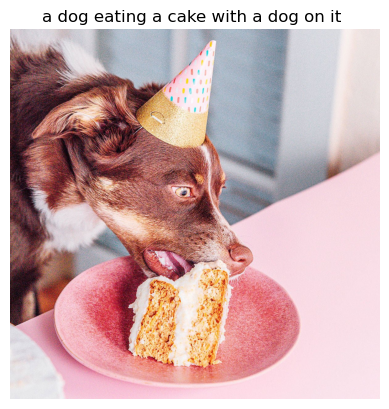

In [11]:
from transformers import pipeline, logging

# Ignorar todo warning
logging.set_verbosity_error()

vit_gpt2 = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
caption = vit_gpt2("datos/dog_cake.jpg")

# Sacar la imagen con matplot y poner de titulo lo generado por el modelo
img = mpimg.imread('datos/dog_cake.jpg')
plt.imshow(img)
plt.title(caption[0]['generated_text'])
plt.axis('off')
plt.show()

## EJERCICIO 6
Elige un modelo de detcción de objetos de Hugging Face y aplícalo a una imagen.

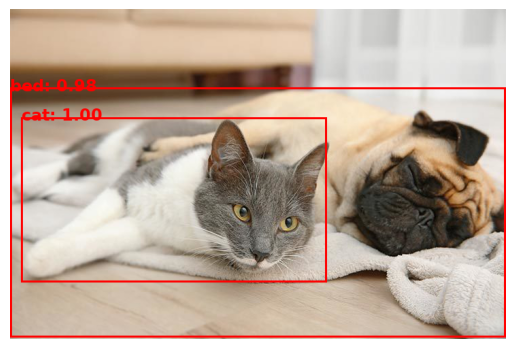

In [13]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Cargar la imagen local
image_path = "datos/cat_dog.jpg"
image = Image.open(image_path)

# Cargar el modelo y el procesador (tokenizador)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Preprocesar la imagen
inputs = processor(images=image, return_tensors="pt")

# Realizar la inferencia
with torch.no_grad():
    outputs = model(**inputs)

# Convertir las salidas (cajas y logits de clase) a la API de COCO
target_sizes = torch.tensor([image.size[::-1]])  # tamaño original de la imagen
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

# Dibujar los cuadros de las predicciones sobre la imagen
draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # Dibujar el cuadro delimitador
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, outline="red", width=3)
    
    # Mapear la etiqueta numérica a su nombre de clase correspondiente en COCO
    label_name = model.config.id2label[label.item()]
    label_text = f"{label_name}: {score:.2f}"  # Nombre de la clase y la puntuación de confianza
    
    # Definir la fuente
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    # Dibujar el texto sobre el cuadro (posición, texto, color)
    # Usamos textbbox para obtener el tamaño del texto
    bbox = draw.textbbox((0, 0), label_text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Colocar el texto encima del cuadro
    text_position = (box[0], box[1] - text_height)  # Ajuste para que el texto quede encima de la caja
    draw.text(text_position, label_text, fill="red", font=font)

# Mostrar la imagen con los cuadros y etiquetas
plt.imshow(image)
plt.axis("off")  # Desactivar los ejes
plt.show()


## EJERCICIO 7
Genera un texto usando un modelo de generción de texto (gpt2).
Usa el texto creado como entrada para un modelo de generación de imágenes (stable-diffusion).

El texto de entrada para el primer modelo va a ser

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
100%|██████████| 50/50 [02:51<00:00,  3.44s/it]


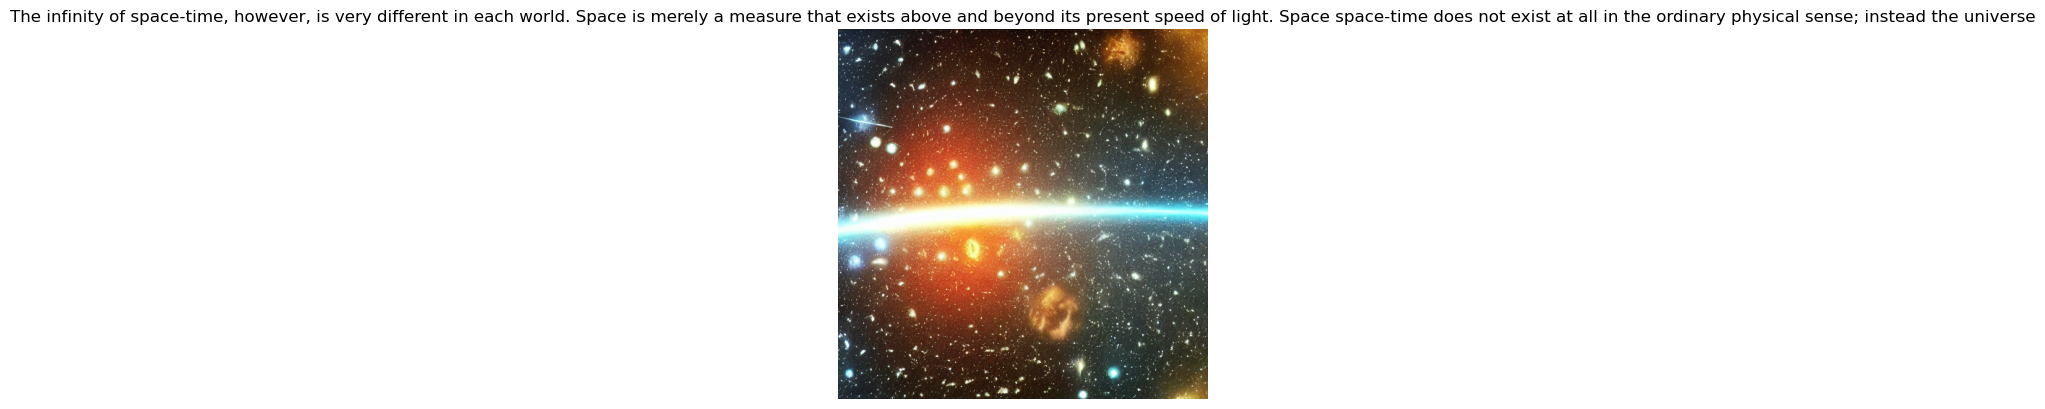

In [18]:
from transformers import pipeline
from diffusers import DiffusionPipeline

gpt2 = pipeline("text-generation", model="openai-community/gpt2")
text = "The infinity of space"
generated = gpt2(text)

pipe = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5")
prompt = generated[0]['generated_text']
image = pipe(prompt).images[0]

plt.imshow(image)
plt.title(prompt)
plt.axis('off')
plt.show()

In [19]:
image.save("Resultados/diffusion.jpg")

## EJERCICIO 8 (OPCIONAL)
Encadena con sentido tres modelos de Hugging Face para realizar una tarea de NLP, una de visión y una de generación de imágenes.